## Portfolio: Walmart Weekly Sales Forecast ##
This is a portfolio based on the historical sales data for 45 Walmart stores located in different regions of the United States. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact. The dataset can be found here https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data.

**Goal:**
To predict the weekly sales forecasts across 45 different regional stores evaluated by mean-absolute-errors (MAEs).

**Results:** 
By comparing the different regressor model performances, RandomForest was the best with MAE: 1308 on a test set.

**Risks:** With visual inspection from residual and quantile plots, there were some errors for making accurate predictions. Especially, from low to middle range of weekly sales were deviated a lot from forecasted weekly sales.

**Mitigation:** 
Review these identified errors and outliers with Walmart store manager(s) and operation/marketing directors before making any promotional markdown events to generate more revenue across the different stores.

**Future Work:**
1. Model improvements: feasibility of testing other ensemble models, stacking and neural network.
2. Data collection/refinement: integrate with other financial and job market-related data sources 
    * Household income by Walmart store regions 
    * KPIs on accessibility to Walmart stores (i.e., # of store visits, # of parking tickets issued, etc.)

**Recommendation for clients:** 
1. Support the development plan for different departments and stores.
2. *

## Part 1 - DEFINE ##

**Problem Statement:** 
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains several departments, and you are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**Stakeholders:** 
Marketing/Operational Director(s), Store Manager(s), Data Science Team

**Goal:**
To predict the weekly sales forecast model for time-series problem(s).

In [1]:
# Import all libraries #
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import statsmodels.api as sm
import scipy.stats as sp
import sklearn.metrics as skm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

## Part 2 - DISCOVERY ##

In [2]:
# --- 2. Write Out List of Functions --- #
def load_file(file):
    '''load csv file as a dataframe'''
    df = pd.read_csv(file)
    return df

def drop_column_by_index(df, var_list):
    '''drop a column by index'''
    df = df.drop(var_list, axis=1)
    return df

def join_data(df_1, df_2, join_type, left_keys, right_keys,
              left_index=None, right_index=None):
    '''merge the dataframe(s) based on the key'''
    df_join = pd.merge(df_1, df_2, how=join_type, left_on=left_keys,
                       right_on=right_keys, left_index=False, right_index=False)
    return df_join

def clean_data(df, key):
    '''drop any duplicates based on a specified column'''
    clean_df = df.drop_duplicates(subset=key)
    return clean_df

def convert_dt_as_category(df):
    '''convert data type from object to category'''
    for var_name in df.columns:
        if df[var_name].dtype.name == 'object':
            df[var_name] = df[var_name].astype('category')
            
def convert_dt_as_object(df):
    '''convert data type from category to object'''
    for var_name in df.columns:
        if df[var_name].dtype.name == 'category':
            df[var_name] = df[var_name].astype('object')
            
def EDA_missing_data(df):
    '''computes missing % on train data'''
    missing_df = pd.DataFrame(df.isnull().sum())
    missing_df.columns = ['count']
    missing_df = missing_df.sort_values(by='count', ascending=False)
    missing_df['pct'] = missing_df['count']/len(df)
    return missing_df

def EDA_summary_stat_num(df):
    '''shows the summary statistics on numerical var'''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'max', 'mean', 'std', '25%', '50%', '75%']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num

def EDA_summary_stat_cat(df):
    '''shows the summary statistics on categorical var'''
    df_stat_cat = df.describe(include='O').T
    df_stat_cat = pd.DataFrame(df_stat_cat)
    return df_stat_cat

def EDA_plot_corr_matrix(df, features, label):
    '''plot the correlation matrix'''
    corr = df[features+label].corr()
    # Create a mask:
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                annot=True, fmt=".2f", mask=mask)
    plt.xticks(rotation=90)
    plt.show()

def EDA_plot_scatter(df, 
                     var1, lab1, c1,
                     var2, lab2, c2,
                     factor=None):
    '''plot a scatter plot of 2 by 1 figure'''
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.4, wspace=0.9)
    plt.subplot(2,1,1)
    plt.scatter(df[var1]*factor, df['Weekly_Sales'], color=c1)
    plt.title('Scatterplot between '+ lab1 + ' and Weekly Sales')
    plt.xlabel(lab1)
    plt.ylabel('Weekly_Sales')
    
    plt.subplot(2,1,2)
    plt.scatter(df[var2]*factor, df['Weekly_Sales'], color=c2)
    plt.title('Scatterplot between '+ lab2 + ' and Weekly Sales')
    plt.xlabel(lab2)
    plt.ylabel('Weekly_Sales')

def missing_val_imputer(df):
    '''impute missing values based on specific data type and a column'''
    for column in df.columns:
        if df[column].dtype.name == 'object':
            mode = df[column].mode()
            df[column] = df[column].fillna(str(mode))
        elif df[column].dtype.name == 'float64':
            mean = df[column].mean()
            df[column] = df[column].fillna(mean)
        elif df[column].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            df[column] = df[column].fillna(pseudo_date)
        else:
            md_cols = df.columns[df.columns.str.contains(pat = 'MarkDown')]
            df[md_cols] = df[md_cols].fillna(0)

def split_dataframe(df):
    '''Split data into train and test sets'''
    df_final_train, df_final_test = df.loc[df['File_Type']=='Train'], df.loc[df['File_Type']=='Test']
    return df_final_train, df_final_test

def format_dummy_vars(df, var_name):
    '''Format dummy variables in recognized names'''
    df[var_name] = var_name + '_' + df[var_name].map(str)

def get_dummies(df, var_name):
    '''Create a list of dummy vars'''
    dummies = pd.get_dummies(df[var_name], drop_first=True)
    return dummies

def feature_scaler(df, var_name):
    '''scale feature based on standard normalization'''
    df[var_name] = (df[var_name] - df[var_name].mean())/(df[var_name].std())
    

def model_tuning_param(model, X_train, y_train, param_dist, n_iter):
    '''Performs RandomizedSearchCV to tune model parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=2)
    random_search.fit(X_train, y_train)
    return random_search


def print_best_params(random_search, param_1=None, param_2=None, param_3=None):
    '''Print the best model parameters'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])
    

def model_train(model, X_train, y_train, n_proc, mean_mae, cv_std):
    '''Train a model and output mean MAE and CV Std. MAE'''
    neg_mae = cross_val_score(model, X_train, y_train, n_jobs=n_proc, cv=5,
                              scoring='neg_mean_absolute_error')
    mae = -1*neg_mae
    mean_mae[model] = np.mean(mae)
    cv_std[model] = np.std(mae)

def model_summary(model, mean_mae, cv_std):
    '''Print out the model performance summary'''
    print('\nModel:\n', model)
    print('Average MAE:\n', mean_mae[model])
    print('Std. Dev during CV:\n', cv_std[model])

def gen_predictions_file(df, var_1, var_2, var_3):
    '''Generate test predictions file: concatenate with 3 keys to make the id column'''
    df['id'] = df[var_1].map(str)+'_'+df[var_2].map(str)+'_'+df[var_3].map(str)
    return df[['id', 'Weekly_Sales_Pred']]


def model_results(model, mean_mae, predictions, feature_importances):
    '''Saves the model name, mean_mae, predicted sales, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv',index=False)
        df_predictions.to_csv('final_predictions.csv',index=False)

        
def plot_reg_compare(y_train_pred, y_train_act):
    '''Plot a scatter plot to compare predicted vs actual label'''
    plt.scatter(y_train_act, y_train_pred, c='blue', 
                edgecolor='w', marker='o', label='train set')
    plt.xlabel('Actual Weekly Sales')
    plt.ylabel('Predicted Weekly Sales')
    plt.legend(loc='upper left')
    
    
def plot_reg_residual(y_train_pred, y_train_act):
    '''Plot a scatter plot to visualize residual from predicted vs. actual label'''
    plt.scatter(y_train_pred, (y_train_pred - y_train_act),  c='blue',
                edgecolor='w', marker='o', label='train set')
    plt.hlines(y=0, xmin=-100000, xmax=500000, colors='k', lw=3)
    plt.ylim([-100000,100000])
    plt.xlabel('Predicted Weekly Sales')
    plt.ylabel('Residual Weekly Sales')
    plt.legend(loc='upper left')

In [3]:
# --- 3. Load the data --- #
# Define input CSVs:
if __name__ == '__main__':
    test_data = 'sales_test.csv'
    train_data = 'sales_train.csv'
    store_data = 'sales_stores.csv'
    feature_data = 'sales_features.csv'

# Load data
df_test = load_file(test_data)
df_train = load_file(train_data)
df_store = load_file(store_data)
df_feature = load_file(feature_data)

# Create a column file_type: distinguish train & test files for model training
df_train['File_Type'] = 'Train'
df_test['File_Type'] = 'Test'

# Re-order columns on df_train:
df_train = df_train[['Store','Dept','Date','IsHoliday','File_Type','Weekly_Sales']]


# Concatenate df_train and df_test as one dataframe:
df = pd.concat([df_train, df_test], axis=0)

# 1st Join: left join on the feature and store data
df_join_1 = join_data(df_feature, df_store, 'left', 'Store', 'Store')
# Final Join: left join on the train and joined dataframe
df_join_final = join_data(df, df_join_1, 'left', 
                          ['Store', 'Date', 'IsHoliday'], ['Store', 'Date', 'IsHoliday'])

del(df, df_join_1)
del(df_test, df_train, df_store, df_feature)

# Define variables: 
features = ['Date', 'Type', 'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'CPI', 'Unemployment' ]

label_var = ['Weekly_Sales']

id_var_1 = 'Store'
id_var_2 = 'Dept'
id_var_3 = 'Date'

var_list = [id_var_1, id_var_2, id_var_3]

# Drop a column by index: poverty_rate
df_label = df_join_final[['Store', 'Dept', 'Date', 'Weekly_Sales']]
df_staging = drop_column_by_index(df_join_final, label_var)
del df_join_final

# Join the train and label:
df_raw = join_data(df_staging, df_label, 'inner', var_list, var_list)
del df_staging

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
# --- 4. Perform data cleaning and quality check --- #
# Compute missing value % on a dataframe:
# MarkDown 1-5 missing values more than 50%
missing_df_train = EDA_missing_data(df_raw)
missing_df_train

,count,pct
MarkDown2,338949,0.631620
MarkDown4,299491,0.558092
MarkDown3,294308,0.548433
MarkDown1,271038,0.505070
MarkDown5,270138,0.503393
Weekly_Sales,115064,0.214418
CPI,38162,0.071114
Unemployment,38162,0.071114
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [5]:
# --- 5. Feature encoding on numerical variables --- #
# Convert the temperature from Fahrenheit to Celsius
df_raw['Temperature'] = (df_raw['Temperature'] - 32) * 5/9

# Format Date based on the date_format
date_format = '%Y-%m-%d'
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

In [6]:
# --- 6. Explore the data (EDA) --- # 
# Compute summary statistics
df_stat_num = EDA_summary_stat_num(df_raw)
df_stat_num

,count,min,max,mean,std,25%,50%,75%
MarkDown2,197685.0,-265.760000,104519.540000,3509.274827,8992.047197,72.500000,385.310000,2392.390000
MarkDown4,237143.0,0.220000,67474.850000,3371.556866,6872.281734,336.240000,1239.040000,3397.080000
MarkDown3,242326.0,-179.260000,149483.310000,1857.913525,11616.143274,7.220000,40.760000,174.260000
MarkDown1,265596.0,-2781.450000,103184.980000,7438.004144,9411.341379,2114.640000,5126.540000,9303.850000
MarkDown5,266496.0,-185.170000,771448.100000,4324.021158,13549.262124,1570.112500,2870.910000,5012.220000
Weekly_Sales,421570.0,-4988.940000,693099.360000,15981.258123,22711.183519,2079.650000,7612.030000,20205.852500
CPI,498472.0,126.064000,228.976456,172.090481,39.542149,132.521867,182.442420,213.748126
Unemployment,498472.0,3.684000,14.313000,7.791888,1.865076,6.623000,7.795000,8.549000
Dept,536634.0,1.000000,99.000000,44.277301,30.527358,18.000000,37.000000,74.000000
Store,536634.0,1.000000,45.000000,22.208621,12.790580,11.000000,22.000000,33.000000


In [7]:
df_stat_cat = EDA_summary_stat_cat(df_raw)
df_stat_cat

,count,unique,top,freq
File_Type,536634,2,Train,421570
Type,536634,3,A,274191


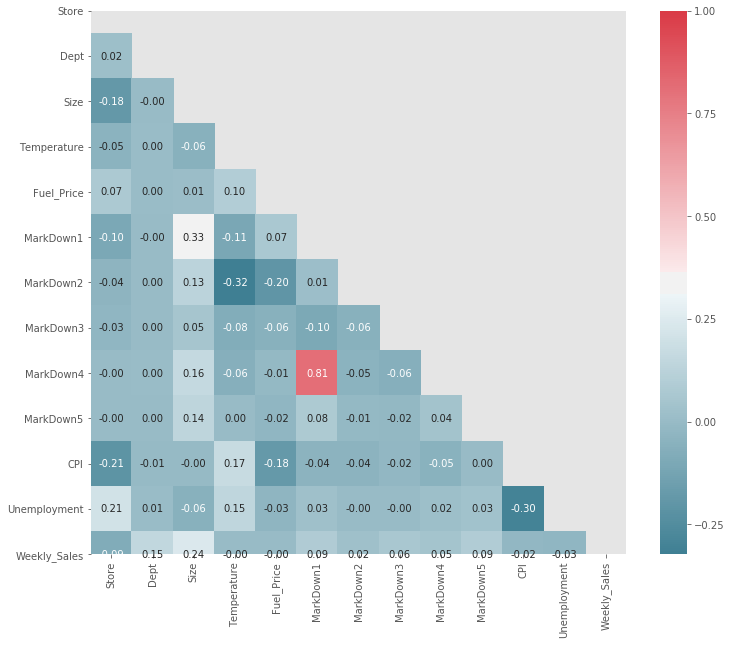

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2011-08-26     1
2010-02-05     1
Name: Date, dtype: int64

In [8]:
# Correlation matrix plot # 
###########################    
# Compute the correlation of each feature against weekly sales: order of magnitude
EDA_plot_corr_matrix(df_raw, features, label_var)

# Verify the Weekly Sales > 300K:
df_raw.loc[df_raw['Weekly_Sales'] > 300000]

# Check the dates where Weekly_Sales > 240K:
# 2 days before Christmas and Black Friday (*)
df_raw.loc[df_raw['Weekly_Sales'] > 240000, "Date"].value_counts()

### Summary: Correlation Matrix ###
There are a few interesting relationships to note here.

1. A moderate positive correlation between Size and Weekly Sales (r-value = 0.24)
2. A weak positive correlation between department on Weekly Sales (r-value = 0.15)
3. A weak negative correlation between store on Weekly Sales (r-value = -0.09)
4. A strong positive correlation between MarkDown1 and MarkDown4 promotial sales (r-value = 0.81)

#### Feature Engineering 1 ####
Feature engineering is a process where feature are generated by data transformation of existing feature(s). 

**Nominal feature encoding:** markdown promotional sales availability/presence md1_presence to md5_presence is a nominal feature where it can be described by binary digits (0 or 1)

In [9]:
# --- 7. Feature engineering on categorical variables --- #
#############################################################
# Feature Engineering: indicate(s) presence of MarkDown 1-5 #
#############################################################
df_raw = df_raw.assign(md1_presence = df_raw.MarkDown1.notnull())
df_raw = df_raw.assign(md2_presence = df_raw.MarkDown2.notnull())
df_raw = df_raw.assign(md3_presence = df_raw.MarkDown3.notnull())
df_raw = df_raw.assign(md4_presence = df_raw.MarkDown4.notnull())
df_raw = df_raw.assign(md5_presence = df_raw.MarkDown5.notnull())

####  Feature Imputation ####
Let's compute feature imputation to replace missing values by following:
* Mode: categorical features
* Mean: numerical features
* Max: pseudo time stamp on missing date(s)
* Custom: customized values to fill na (i.e., fillna with zero(s))

In [10]:
# --- 8. Feature imputation via univariate techniques --- #    
# make df_imputed:
df_imputed = df_raw.copy()
df_imputed.dtypes

# For all missing values on MarkDown 1-5, just replaced them with "0"
missing_val_imputer(df_imputed)

# check any missing values on imputed df:
df_imputed.isnull().sum()

Date            0
Dept            0
File_Type       0
IsHoliday       0
Store           0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Weekly_Sales    0
md1_presence    0
md2_presence    0
md3_presence    0
md4_presence    0
md5_presence    0
dtype: int64

#### One-Hot-Encoding: dummy variable  ####
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted by the ML models.

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: Christmas_Eves_yes vs. Christmas_Eves_no).

In [11]:
# --- 9. One-hot-encode on features --- # 
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
# Create a dummy variable: date
df_imputed['Date_String'] = [datetime.strptime(date, '%Y-%m-%d').date() 
                            for date in df_imputed['Date'].astype(str).values.tolist()]
df_imputed['Month'] = [date.month for date in df_imputed['Date_String']]

# Create a list of dummy variables: Special Dates - Black Friday & Christmas Eve
df_imputed['Black_Friday'] = np.where((df_imputed['Date_String']==datetime(2010, 11, 26).date()) | 
        (df_imputed['Date_String']==datetime(2011, 11, 25).date()), 'yes', 'no')
df_imputed['Christmas_Eves'] = np.where((df_imputed['Date_String']==datetime(2010, 12, 23).date()) | 
        (df_imputed['Date_String']==datetime(2010, 12, 24).date()) | 
        (df_imputed['Date_String']==datetime(2011, 12, 23).date()) | 
        (df_imputed['Date_String']==datetime(2011, 12, 24).date()), 'yes', 'no')

# Re-format dummy variables: Type, Store, Dept and IsHoliday
#format_dummy_vars(df_imputed, 'Type')
#format_dummy_vars(df_imputed, 'Store')
#format_dummy_vars(df_imputed, 'Dept')
format_dummy_vars(df_imputed, 'Month')
format_dummy_vars(df_imputed, 'IsHoliday')
format_dummy_vars(df_imputed, 'Black_Friday')
format_dummy_vars(df_imputed, 'Christmas_Eves')

# Create a list of dummy variables:
#type_dummies = get_dummies(df_imputed, 'Type')
#store_dummies = get_dummies(df_imputed, 'Store') 
#dept_dummies = get_dummies(df_imputed, 'Dept')
month_dummies = get_dummies(df_imputed, 'Month')
holiday_dummies = get_dummies(df_imputed, 'IsHoliday')
black_friday_dummies = get_dummies(df_imputed, 'Black_Friday')
christmas_eve_dummies = get_dummies(df_imputed, 'Christmas_Eves')

del df_raw

# Concatenate dataframe: use the special date dummies for now #
df_cleaned = pd.concat([df_imputed, christmas_eve_dummies, 
                              black_friday_dummies, holiday_dummies], axis=1)

#### Feature Engineering 2 ####

**Arithmetic Operation/Time Intelligence**. 
Feature engineering techniques are applied to generate following feature(s):

1. 'Median_Sales' = computation of median weekly sales value on training dataset only!
2. 'Lagged_1wk_Sales' = computation of 1week lagging weekly sales
3. 'Lagged_1wk_Available' = computation of a categorical feature whether or not 1week lagging weekly sales are available!

In [12]:
# --- 10. Feature engineering on numerical variables --- #
# Create store median sales by store and department on train set only!
df_median_sales = pd.DataFrame({'Median_Sales':df_cleaned.loc[df_cleaned['File_Type']=='Train'].groupby(
                  by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()

df_median_sales.head()

# Perform outer join on df_cleaned and df_median_sales:
df_cleaned = join_data(df_cleaned, df_median_sales, 'outer',
                           ['Type','Dept','Store','Month','IsHoliday'],
                           ['Type','Dept','Store','Month','IsHoliday'])
del(df_median_sales)

# Imputed Median_Sales for NAs:
df_cleaned['Median_Sales'].fillna(df_cleaned['Median_Sales'].loc[df_cleaned['File_Type']=='Train'].median()
                                  ,inplace=True)

# Create a lagging variable: store's 1wk lagged weekly sales
df_cleaned['Date_Lagged_1wk'] = df_cleaned['Date_String'] - timedelta(days=7)
df_cleaned.head()

# Create a sorted dataframe: 1wk lagged weekly sales computation
df_lagged_sales = df_cleaned.sort_values(['Store', 'Dept', 'Date_String'], ascending=[True,True,True])
df_lagged_sales = df_lagged_sales.reset_index(drop=True)

# Create Lagged_1wk_Sales, Lagged_1wk_Available
# Initialize features: Lagged_1wk_Sales, Lagged_1wk_Available
df_lagged_sales['Lagged_1wk_Sales'] = np.nan
df_lagged_sales['Lagged_1wk_Available'] = np.nan
row_last = df_cleaned.loc[0]
row_len = df_lagged_sales.shape[0]
for index, row in df_lagged_sales.iterrows():
    lag_date = row['Date_Lagged_1wk']
    # Check if it matches the last week sales to the compared date
    if((row_last['Date_String'] == lag_date) & (row_last['Weekly_Sales']>0)):
        df_lagged_sales.set_value(index, 'Lagged_1wk_Sales', row_last['Weekly_Sales'])
        df_lagged_sales.set_value(index, 'Lagged_1wk_Available', 1)
    else: #replace with median sales
        df_lagged_sales.set_value(index, 'Lagged_1wk_Sales', row['Median_Sales'])
        df_lagged_sales.set_value(index, 'Lagged_1wk_Available', 0)
    row_last = row # compute last row for computational speed
    if(index%int(row_len/10)==0): # shows progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% computed')
        
# Checked the engineered features:
df_lagged_sales[['Dept','Store','Date_String','Lagged_1wk_Sales','Weekly_Sales','Median_Sales']].head()        

df_cleaned = df_lagged_sales.copy()
del(df_lagged_sales)

# Compute Variance_Sales: Median_Sales - Lagged_1wk_Sales
df_cleaned['Sales_Var_Median_Lagged'] = df_cleaned['Median_Sales'] - df_cleaned['Lagged_1wk_Sales']

# Checked the engineered features:
df_cleaned[['Dept','Store','Date_String','Weekly_Sales','Median_Sales','Lagged_1wk_Sales','Sales_Var_Median_Lagged']].head()

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


0% computed
9% computed
19% computed
29% computed
39% computed
49% computed
59% computed
69% computed
79% computed
89% computed
99% computed


,Dept,Store,Date_String,Weekly_Sales,Median_Sales,Lagged_1wk_Sales,Sales_Var_Median_Lagged
0,1,1,2010-02-05,24924.50,23510.49,23510.49,0.00
1,1,1,2010-02-12,46039.49,37887.17,24924.50,12962.67
2,1,1,2010-02-19,41595.55,23510.49,46039.49,-22529.00
3,1,1,2010-02-26,19403.54,23510.49,41595.55,-18085.06
4,1,1,2010-03-05,21827.90,21280.40,19403.54,1876.86


In [13]:
# --- 11. Feature Scaling --- # 
# Normalized features based on standardization
#df_cleaned['Temperature'] = feature_scaler(df_cleaned, 'Temperature')

# Compute Variance_Sales: Median_Sales - Weekly_Sales
df_cleaned['Sales_Var_Median_Weekly'] = df_cleaned['Median_Sales'] - df_cleaned['Weekly_Sales']


# --- 12. Feature selection --- # 
selection = ['CPI', 'Fuel_Price', 'Size', 'Temperature', 'Unemployment',
             'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
             'md1_presence','md2_presence', 'md3_presence', 'md4_presence', 'md5_presence', 
             'IsHoliday_True', 'Christmas_Eves_yes', 'Black_Friday_yes', 
             'Lagged_1wk_Sales', 'Lagged_1wk_Available', 'Sales_Var_Median_Lagged']

# Compute the EDA on selected features:
df_cleaned[selection].describe()
df_cleaned[selection].head()

# Save feature_df for EDA portfolio:
df_eda = df_cleaned[df_cleaned['File_Type']=='Train']
df_eda.to_csv('df_eda.csv', index=False)

In [14]:
# --- 13. Establish a baseline model --- # 
# Split the data for train and test sets:
df_final_train, df_final_test = split_dataframe(df_cleaned)

# Spit the data into features and label:
np.random.seed(100)
X_train, X_val, y_train, y_val = train_test_split(df_final_train[selection], df_final_train['Sales_Var_Median_Weekly'],
                                                  test_size=1/4, random_state=100)
print(X_val.shape)
print(y_val.shape)


# Establish a baseline model:
baseline = LinearRegression()
baseline_cv = cross_val_score(baseline, X_train,  y_train.ravel(),
                              cv=5, scoring='neg_mean_absolute_error')
baseline_mae = -1 * baseline_cv
baseline_mean_mae = np.mean(baseline_mae)
print('Baseline MAE: ' + str(baseline_mean_mae))

(105393, 21)
(105393,)
Baseline MAE: 1565.1893867223248


#### Baseline Model ####
Baseline model was computed to compare the performance across different set of hyper-parameters tuned models.
The Baseline MAE was 1565.19.

## Part 3 - DEVELOP ##

In [15]:
############################
# Part 3 - DEVELOP PHASE ###
############################
# --- 14. Create models --- # 
# initialize model list and dicts
models = []
mean_mae = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: RandomForest
rf = RandomForestRegressor()
n_iter=10
param_dist_rf = {'n_estimators':sp.randint(10,80), 
                  'min_samples_split':sp.randint(2,10),
                  'min_samples_leaf':sp.randint(2,10)}

random_search_rf = model_tuning_param(rf, X_train, y_train.ravel(), param_dist_rf, n_iter)   

# print the best model parameters: RandomForest    
param_1 = 'n_estimators' 
param_2 = 'min_samples_split'
param_3 = 'min_samples_leaf'
    
print_best_params(random_search_rf, param_1, param_2, param_3)
###############################################################################    
# Hyper-parameters tuning: GradientBoosting
gbr = GradientBoostingRegressor()
n_iter = 10
param_dist_gbr = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(2,20),
                  'loss':['ls']}

random_search_gbr = model_tuning_param(gbr, X_train, y_train.ravel(), param_dist_gbr, n_iter)    
    
# print the best model parameters: GradientBoosting    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'loss'
    
print_best_params(random_search_gbr, param_1, param_2, param_3) 
###############################################################################    
# Hyper-parameters tuning: XGBoost
xgb = XGBRegressor()   
n_iter = 10
param_dist_xgb = {'n_estimators':sp.randint(10,40), 
                  'max_depth':sp.randint(2,20),
                  'learning_rate':np.random.uniform(0,1,10)}

random_search_xgb = model_tuning_param(xgb, X_train, y_train.ravel(), param_dist_xgb, n_iter)    
    
# print the best model parameters: XGBRegressor    
param_1 = 'n_estimators' 
param_2 = 'max_depth'
param_3 = 'learning_rate'
    
print_best_params(random_search_xgb, param_1, param_2, param_3)
###############################################################################  

Best n_estimators: 76
Best min_samples_split: 7
Best min_samples_leaf: 4
Best n_estimators: 38
Best max_depth: 12
Best loss: ls
[21:41:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:37] WARNING: src/objective/regression_obj.cu:152: reg

In [16]:
# --- 15. Cross-validate models --- # 
#do 5-fold cross validation on models and measure MAE
# Model List to train: Order of Model Complexity
rf = RandomForestRegressor(n_estimators=61, n_jobs=n_proc, min_samples_split=2,
                               min_samples_leaf=4, verbose=verbose_lv)   
gbr = GradientBoostingRegressor(n_estimators=38, max_depth=10, loss='ls', verbose=verbose_lv)
xgb = XGBRegressor(n_estimators=24, max_depth=10, learning_rate=0.18949843940084687) 

models.extend([rf, gbr, xgb])    

# cross-validate models, using MSE to evaluate and print the summaries
print("begin cross-validation")
for model in models:
    model_train(model, X_train, y_train.ravel(), n_proc, mean_mae, cv_std)
    model_summary(model, mean_mae, cv_std)
    
# --- 16. Select the best model with lowest MAE for predictions --- #
# Best Model RF: MAE = 1308, CV_STD_MAE = 9.40
model = min(mean_mae, key=mean_mae.get)
print('\nBest model with the lowest MAE:')
print(model)

begin cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.5s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.3s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.5s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.5s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.9s finished



Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=1,
                      oob_score=False, random_state=None, verbose=5,
                      warm_start=False)
Average MAE:
 1308.8252180597658
Std. Dev during CV:
 9.588939253283996
      Iter       Train Loss   Remaining Time 
         1    14331780.7827            2.45m
         2    13231402.2406            2.33m
         3    12335272.0438            2.23m
         4    11561155.0330            2.20m
         5    10916843.4697            2.16m
         6    10391824.1131            2.10m
         7     9941871.2069            2.06m
         8     9539343.8948            2.01m
         9     9199067.7032            1.94m
        

        14     8059743.0846            1.58m
        15     7905919.9296            1.51m
        16     7759530.4705            1.44m
        17     7616283.5309            1.37m
        18     7483468.3004            1.31m
        19     7327445.2813            1.25m
        20     7219434.9344            1.17m
        21     7135002.9210            1.11m
        22     7036608.8147            1.04m
        23     6945679.1723           58.47s
        24     6838555.5330           54.63s
        25     6768865.7684           50.70s
        26     6696335.3333           46.50s
        27     6615991.9909           42.56s
        28     6561714.1845           38.17s
        29     6515029.7705           33.89s
        30     6464788.2073           29.99s
        31     6412245.4673           26.00s
        32     6366106.7921           22.17s
        33     6322848.1111           18.27s
        34     6269890.3163           14.55s
        35     6246052.0691           10.80s
        36

In [17]:
# Model Validation with Regression Plots:
# Fit the best model:
model.fit(X_train, y_train.ravel())

# Make predictions:
y_pred_var_med_weekly = model.predict(X_val)
y_val = y_val.to_frame() #Sales Variance = [Median - Weekly Sales]
y_val['Sales_Var_Med_Weekly_Pred'] = y_pred_var_med_weekly #Sales Variance Predicted

df_best = pd.merge(df_final_train, y_val[['Sales_Var_Med_Weekly_Pred']], how='left', 
                  left_index=True, right_index=True, suffixes=['_True','_Pred'])

# Remove rows where Sales_Var_Med_Weekly_Pred is Null:
df_best = df_best[~pd.isnull(df_best['Sales_Var_Med_Weekly_Pred'])]
df_best.head()

# Derive the Weekly Sales Prediction: Median Sales - (Median Sales - Weekly Sales)_Pred
df_best['Weekly_Sales_Pred'] = df_best['Median_Sales']-df_best['Sales_Var_Med_Weekly_Pred']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


building tree 2 of 61


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


building tree 3 of 61


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s


building tree 4 of 61


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.8s remaining:    0.0s


building tree 5 of 61
building tree 6 of 61
building tree 7 of 61
building tree 8 of 61
building tree 9 of 61
building tree 10 of 61
building tree 11 of 61
building tree 12 of 61
building tree 13 of 61
building tree 14 of 61
building tree 15 of 61
building tree 16 of 61
building tree 17 of 61
building tree 18 of 61
building tree 19 of 61
building tree 20 of 61
building tree 21 of 61
building tree 22 of 61
building tree 23 of 61
building tree 24 of 61
building tree 25 of 61
building tree 26 of 61
building tree 27 of 61
building tree 28 of 61
building tree 29 of 61
building tree 30 of 61
building tree 31 of 61
building tree 32 of 61
building tree 33 of 61
building tree 34 of 61
building tree 35 of 61
building tree 36 of 61
building tree 37 of 61
building tree 38 of 61
building tree 39 of 61
building tree 40 of 61
building tree 41 of 61
building tree 42 of 61
building tree 43 of 61
building tree 44 of 61
building tree 45 of 61
building tree 46 of 61
building tree 47 of 61
building tree 48

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.6s finished


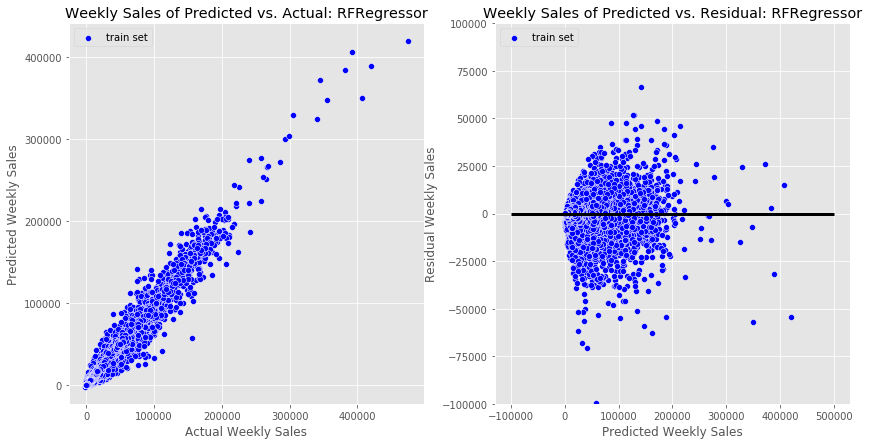

Medians: 1538.7774721755943
Best Model: 1294.1976332330723


In [18]:
# Plot a comparison scatter plot: predicted vs. actual
plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plot_reg_compare(df_best['Weekly_Sales_Pred'], df_best['Weekly_Sales'])
plt.title('Weekly Sales of Predicted vs. Actual: RFRegressor')

# Plot a residual scatter plot: predicted vs. residual
plt.subplot(1,2,2)
plot_reg_residual(df_best['Weekly_Sales_Pred'], df_best['Weekly_Sales'])
plt.title('Weekly Sales of Predicted vs. Residual: RFRegressor')
plt.show()

# Compute the Mean Absolute Error (MAE):
print("Medians: "+str(sum(abs(df_best['Sales_Var_Median_Weekly']))/df_best.shape[0]))
print("Best Model: "+str(sum(abs(df_best['Weekly_Sales']-df_best['Weekly_Sales_Pred']))/df_best.shape[0]))

del(df_best)

### Model Evaluation: Comparison and Residual Plots ###
1st figure showed the straight line which indicated how closely predicted and actual weekly sales were plotted.

2nd figure showed the residual weekly sales across the different predicted weekly sales. 

Thus, higher the predicted weekly sales, greater the residual weekly sales (middle range:). 

### Model Evaluation Summary: Regressor(s) by MAE ###
Each regression model was carefully evaluated using MAE. 
Here is a summarized result of all five tested regression models.

#### 1) RandomForest Regression: ### 
* Avg. MAE test: 1308.82 +/- 9.58

#### 2) GradientBoosting Regression: ###
* Avg. MAE test: 1325.34 +/- 7.40

#### 3) XGBoost Regression: ###
* Avg. MAE test: 1323.12 +/- 9.62

Thus, Random Forest Regressor model was the best model with the least avg. MAE value (1308.8) on a test set. 

## Part 4 - DEPLOY ##

In [19]:
# --- 17. Automate the model pipeline --- #
# make predictions based on a test set
df_pred = model.predict(df_final_test[selection])
df_pred = pd.DataFrame(df_pred)
df_pred.columns = ['Sales_Var_Med_Weekly_Pred']

# make predictions dataframe:
df_predictions = pd.concat([df_final_test.reset_index(drop=True), df_pred], axis=1)
df_predictions['Weekly_Sales_Pred'] = df_predictions['Median_Sales']-df_predictions['Sales_Var_Med_Weekly_Pred']
df_predictions = df_predictions[['Store', 'Dept', 'Date_String', 'Weekly_Sales_Pred']]

del(df_pred)

df_predictions = gen_predictions_file(df_predictions, 'Store', 'Dept', 'Date_String')
df_predictions.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.7s finished


,id,Weekly_Sales_Pred
0,1_1_2012-11-02,25489.666891
1,1_1_2012-11-09,19295.913237
2,1_1_2012-11-16,18866.452718
3,1_1_2012-11-23,19621.412110
4,1_1_2012-11-30,18457.319646


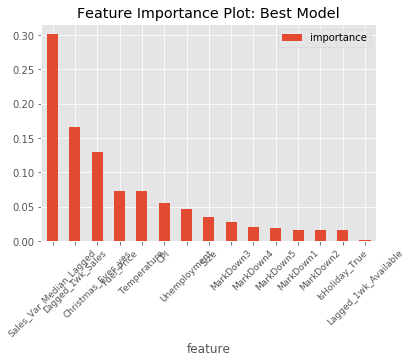

In [20]:
# --- 18. Deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
# linear models don't have one:
    importances = [0]*len(df_final_train.columns)

feature_importances = pd.DataFrame({'feature':df_final_train[selection].columns,
                                    'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#create a plot
feature_importances[0:15].plot.bar(align='center')
plt.xticks(rotation=45, fontsize=9)
plt.title('Feature Importance Plot: Best Model')
plt.show()
    
#Save model results as .csv file:
model_results(model, mean_mae[model], df_predictions, feature_importances)

### Model Summary: Feature Importance ###
A figure showed the feature importance of the best trained model from an order of the highest to lowest ranks.

Top 5 important features were Sales Variance Median-to-Lagged followed by Lagged 1week Sales, and Christmas Eves.